В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from process_bank_churn import preprocess_data, preprocess_new_data

In [ ]:
raw_df = pd.read_csv('train.csv')

In [ ]:
processed_data = preprocess_data(raw_df, scaler_numeric= True)

In [ ]:
X_train, train_targets, X_val, val_targets = processed_data['X_train'], processed_data['train_targets'], processed_data['X_val'], processed_data['val_targets']

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

# Ініціалізуємо kNN-класифікатор з параметрами за замовченням
knn = KNeighborsClassifier()

# Навчаємо модель
knn.fit(X_train, train_targets)

# Робимо передбачення ймовірностей
train_probs = knn.predict_proba(X_train)[:, 1]
val_probs = knn.predict_proba(X_val)[:, 1]

# Обчислюємо AUROC
train_auroc = roc_auc_score(train_targets, train_probs)
val_auroc = roc_auc_score(val_targets, val_probs)

print(f"AUROC на тренувальних даних: {train_auroc:.4f}")
print(f"AUROC на валідаційних даних: {val_auroc:.4f}")

AUROC на тренувальних даних: 0.9559
AUROC на валідаційних даних: 0.8599


AUROC 0.86 на валідаційних даних вказує на хорошу здатність класифікатора відрізняти класи.

Значна різниця між AUROC на тренувальних даних 0.9559 і  валідаційних даних 0.8599 говорить про те, що модель добре запам’ятала тренувальні дані, але дещо гірше генералізує на нові. Це ознака високої варіативності (high variance), тобто наша модель перенавчається.

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [ ]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
params_knn = {'n_neighbors': np.arange(1, 25)}


# Використовуємо GridSearchCV з 5-фолдною крос-валідацією
knn_grid_search = GridSearchCV(knn, params_knn, cv=5, scoring='roc_auc')
knn_grid_search.fit(X_train, train_targets)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             scoring='roc_auc')

In [ ]:
# Отримуємо найкращий параметр n_neighbors
best_n_neighbors = knn_grid_search.best_params_['n_neighbors']
print(f"Найкраще значення n_neighbors: {best_n_neighbors}")

Найкраще значення n_neighbors: 21


In [ ]:
# Збережемо найкращу модель
knn_best = knn_grid_search.best_estimator_

In [ ]:
# Оцінюємо AUROC для кращої моделі
train_probs = knn_best.predict_proba(X_train)[:, 1]
val_probs = knn_best.predict_proba(X_val)[:, 1]

train_auroc_best = roc_auc_score(train_targets, train_probs)
val_auroc_best = roc_auc_score(val_targets, val_probs)

print(f"AUROC на тренувальних даних: {train_auroc_best:.4f}")
print(f"AUROC на валідаційних даних: {val_auroc_best:.4f}")

AUROC на тренувальних даних: 0.9201
AUROC на валідаційних даних: 0.8941


Висновки про якість моделі:

Ми бачимо, що порівняно з попереднім пукнтом цього завдання зменшився розрив між AUROC на тренувальних і валідаційних даних: було 0.9559 і 0.8599, тепер 0.9201 і 0.8941, тобто модель стала більш стійкою до перенавчання.

Зросла якість передбачень на валідаційних даних. Значення AUROC зросло з 0.8599 до 0.894. Це означає, що модель краще генералізує дані.

Якщо порівнювати цю модель з деревом прийняття рішень з попереднього завдання з глибиною max_depth=5, то knn модель показала дещо гірші результати, оскільки decision tree дало Train AUC: 0.9255 і Val AUC: 0.9199.


3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [ ]:
processed_data = preprocess_data(raw_df, scaler_numeric=False)

In [ ]:
X_train, train_targets, X_val, val_targets = processed_data['X_train'], processed_data['train_targets'], processed_data['X_val'], processed_data['val_targets']

In [ ]:
import time
from sklearn.tree import DecisionTreeClassifier

# Визначаємо сітку гіперпараметрів
param_grid = {
    'max_depth': range(1, 21, 2),       # Від 1 до 20 з кроком 2
    'max_leaf_nodes': range(2, 11, 1)   # Від 2 до 10 з кроком 1
}

In [ ]:
# Ініціалізуємо модель з фіксованим random_state
dt = DecisionTreeClassifier(random_state=42)

# Ініціалізуємо GridSearchCV з 3-фольною крос-валідацією
grid_search = GridSearchCV(dt, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# Вимірюємо час виконання
start_time = time.time()
grid_search.fit(X_train, train_targets)
end_time = time.time()

# Час виконання
execution_time = end_time - start_time
print(f"Час виконання GridSearchCV: {execution_time:.2f} секунд")

Час виконання GridSearchCV: 6.01 секунд


In [ ]:
best_params = grid_search.best_params_
print(f"Найкращі значення параметрів: {best_params}")

# Збережемо найкращу модель
dt_best = grid_search.best_estimator_

Найкращі значення параметрів: {'max_depth': 5, 'max_leaf_nodes': 10}


In [ ]:
# Оцінюємо AUROC для кращої моделі
train_probs = dt_best.predict_proba(X_train)[:, 1]
val_probs = dt_best.predict_proba(X_val)[:, 1]

train_auroc_dt = roc_auc_score(train_targets, train_probs)
val_auroc_dt = roc_auc_score(val_targets, val_probs)

print(f"AUROC на тренувальних даних: {train_auroc_dt:.4f}")
print(f"AUROC на валідаційних даних: {val_auroc_dt:.4f}")

AUROC на тренувальних даних: 0.9010
AUROC на валідаційних даних: 0.9018


AUROC на тренувальних даних: 0.9010
AUROC на валідаційних даних: 0.9018

Якість моделі: Модель не має високого bias, оскільки точність на тренувальних і валідаційних даних майже однакова, що свідчить про хорошу генералізацію. Оцінки AUROC вказують на стабільність моделі.

Точність на тренувальних і валідаційних даних для моделі з GridSearchCV дещо знизилася порівняно з вручну налаштованою моделлю.


4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 30),
    'max_leaf_nodes': np.arange(2, 30),
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'max_features': [None, 'sqrt', 'log2']
}

In [ ]:
# Ініціалізуємо модель з фіксованим random_state
dt = DecisionTreeClassifier(random_state=42)

# Ініціалізуємо RandomizedSearchCV з 3-фольною крос-валідацією
random_search = RandomizedSearchCV(
    dt, params_dt, n_iter=40, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1
)

# Вимірюємо час виконання
start_time = time.perf_counter()
random_search.fit(X_train, train_targets)
end_time = time.perf_counter()

# Час виконання
execution_time = end_time - start_time
print(f"Час виконання RandomizedSearchCV: {execution_time:.2f} секунд")

Час виконання RandomizedSearchCV: 1.41 секунд


In [ ]:
best_params_random = random_search.best_params_
print(f"Найкращі значення параметрів (RandomizedSearchCV): {best_params_random}")

# Збережемо найкращу модель
dt_random_search_best = random_search.best_estimator_

Найкращі значення параметрів (RandomizedSearchCV): {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_leaf_nodes': 28, 'max_features': None, 'max_depth': 9, 'criterion': 'entropy'}


In [ ]:
# Оцінюємо AUROC для кращої моделі
train_probs_random = dt_random_search_best.predict_proba(X_train)[:, 1]
val_probs_random = dt_random_search_best.predict_proba(X_val)[:, 1]

train_auroc_random = roc_auc_score(train_targets, train_probs_random)
val_auroc_random = roc_auc_score(val_targets, val_probs_random)

print(f"AUROC на тренувальних даних: {train_auroc_random:.4f}")
print(f"AUROC на валідаційних даних: {val_auroc_random:.4f}")

# Порівняння з GridSearchCV
print(f"Порівняння з GridSearchCV:")
print(f"AUROC (GridSearchCV) train: {train_auroc_dt:.4f}, val: {val_auroc_dt:.4f}")
print(f"AUROC (RandomizedSearchCV) train: {train_auroc_random:.4f}, val: {val_auroc_random:.4f}")

AUROC на тренувальних даних: 0.9293
AUROC на валідаційних даних: 0.9236
Порівняння з GridSearchCV:
AUROC (GridSearchCV) train: 0.9010, val: 0.9018
AUROC (RandomizedSearchCV) train: 0.9293, val: 0.9236


З результатів порівняння видно, що модель з RandomizedSearchCV показала значно кращі результати на тренувальних та валідаційних даних, порівняно з моделлю, яка була оптимізована через GridSearchCV.

На тренувальних даних: AUROC підвищився з 0.9010 до 0.9293.
На валідаційних даних: AUROC покращився з 0.9018 до 0.9236.

Модель з RandomizedSearchCV демонструє вищу точність як на тренувальних, так і на валідаційних даних. Це свідчить про те, що підбір гіперпараметрів через RandomizedSearchCV дав кращі результати завдяки більш варіативному підходу до пошуку параметрів у порівнянні з GridSearchCV.


Модель має досить високу стабільність, а значення AUROC на валідаційних даних не відрізняється суттєво від результатів на тренувальних, що свідчить про хорошу здатність генералізувати на нових даних.

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [ ]:
test_df = pd.read_csv('/content/test.csv')

In [ ]:
# Обробка нових даних за допомогою раніше навчених скейлера та енкодера
test_processed_data = preprocess_new_data(
    new_data=test_df,
    input_cols=processed_data['input_cols'],
    scaler=processed_data['scaler'],
    encoder=processed_data['encoder']
)

In [ ]:
# Робимо пердбачення
test_preds_proba = dt_random_search_best.predict_proba(test_processed_data)[:, 1]

In [ ]:
test_preds_proba

array([0.23140496, 0.01783724, 0.08035714, ..., 0.00483611, 0.03817505,
       0.13278008])

In [ ]:
submission_df = pd.read_csv('/content/sample_submission.csv', index_col=0)

In [ ]:
# Додавання результатів у DataFrame submission_df
submission_df['Exited'] = test_preds_proba

In [ ]:
# Збереження результатів у CSV-файл
submission_df.to_csv('submission_dt_random_search.csv')

In [ ]:
submission_df4 = pd.read_csv('submission_dt_random_search.csv')

In [ ]:
submission_df4

,id,Exited
0,15000,0.231405
1,15001,0.017837
2,15002,0.080357
3,15003,0.440972
4,15004,0.061818
...,...,...
9995,24995,0.017837
9996,24996,0.017837
9997,24997,0.004836
9998,24998,0.038175


На наведеному скріншоті відображені результати роботи моделі з гіперпараметрами, які показували нижчі значення AUROC для тренувальних і валідаційних даних у порівнянні з фінальною моделлю.

Оскільки на момент здачі домашнього завдання було вичерпано всі доступні спроби (submissions) на Kaggle, не було можливості подати модель із більш оптимальними гіперпараметрами для оцінки.

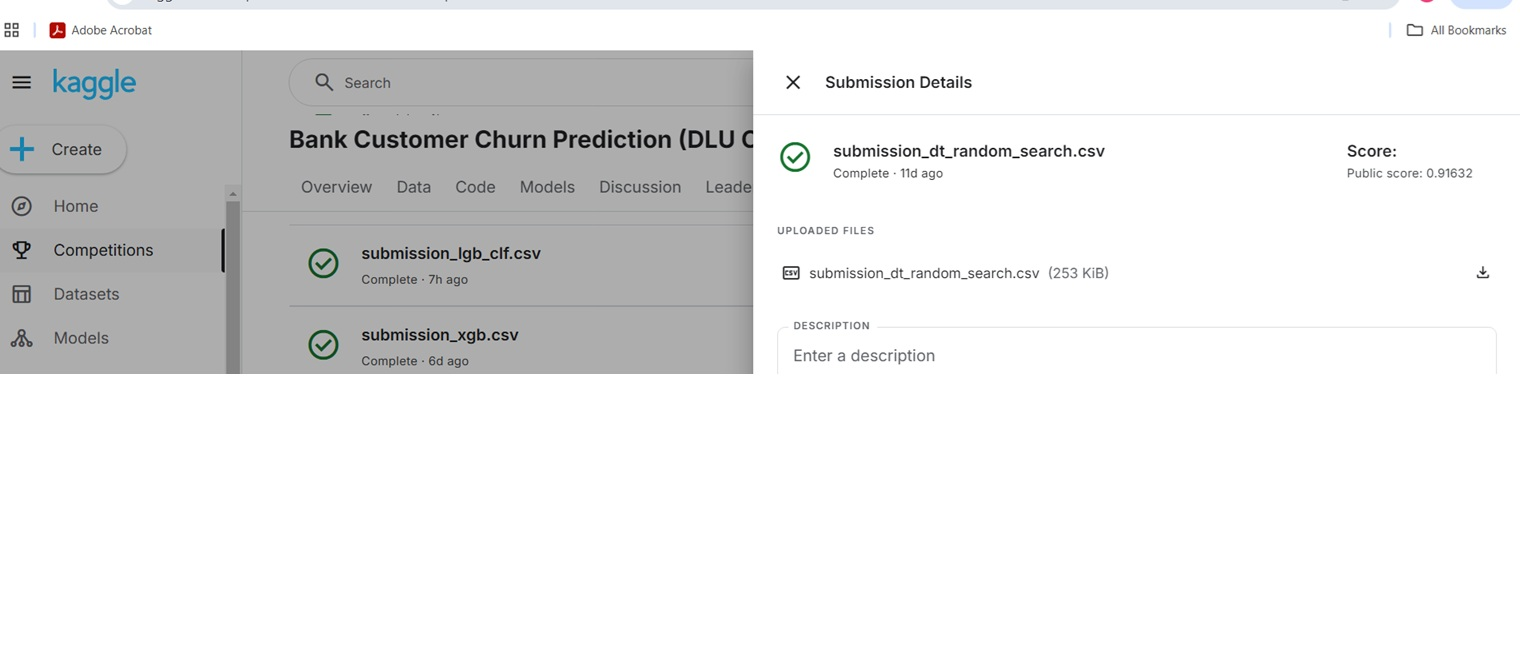

In [2]:
from IPython.display import display
from PIL import Image

image = Image.open('/content/screenshot_kaggle3.jpg')
display(image)